# imported a face mask data set for same cnn network and checked accuracy(Plotted graph)




In [1]:
import numpy
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization
from keras.constraints import maxnorm
from keras.models import Model
from keras.optimizers import *
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import os,cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
# loading data
DIRECTORY = "/content/gdrive/MyDrive/Colab Notebooks/dataset"
categories = ["with_mask", "without_mask"]
labels=[i for i in range(len(categories))]
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
label_dict=dict(zip(categories,labels)) #empty dictionary
img_size=224
data = []
target=[]

for category in categories:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = cv2.imread(img_path)
    	image = img_to_array(image)
    	image = preprocess_input(image)
    	#gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    	resized=cv2.resize(image,(img_size,img_size))
    	data.append(resized)
    	target.append(label_dict[category])


[INFO] loading images...


In [10]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
data = np.array(data, dtype="float32")


target=np.array(target)
lb = LabelBinarizer()
labels = lb.fit_transform(target)
new_target = to_categorical(labels)

#from keras.utils import np_utils

#new_target=np_utils.to_categorical(target)

#Normalize inputs from (0.0 - 255.0) to (0.0 - 1.0)

In [11]:
print(type(data))
print(data.dtype)
print(data.shape)
print(data[251].shape)
print(labels.shape)

<class 'numpy.ndarray'>
float32
(3839, 224, 224, 3)
(224, 224, 3)
(3839, 1)


In [12]:
from sklearn.model_selection import train_test_split
(X_train, X_test,y_train, y_test) = train_test_split(data, new_target,
	test_size=0.20, random_state=42)

#load data

#Create the model

# New Section

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.optimizers import Adam
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
"""H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)"""

[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


'H = model.fit(\n\taug.flow(trainX, trainY, batch_size=BS),\n\tsteps_per_epoch=len(trainX) // BS,\n\tvalidation_data=(testX, testY),\n\tvalidation_steps=len(testX) // BS,\n\tepochs=EPOCHS)'

#Compile model

In [14]:
epochs = 10
lrate = 0.001
adam = tf.keras.optimizers.Adam(learning_rate=lrate)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [24]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

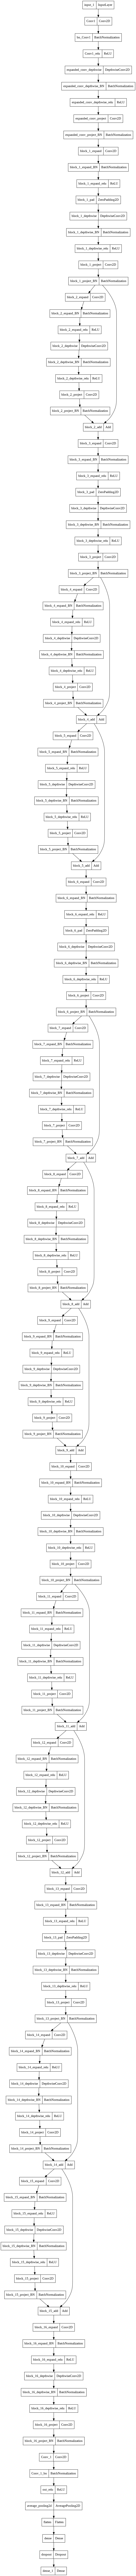

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model)

In [ ]:
#from keras.callbacks import EarlyStopping,ModelCheckpoint
# simple early stopping
#es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)

In [11]:
pip install h5py

In [15]:
mc = ModelCheckpoint('mobilevnetfacemaskdetectionV1.h5', monitor='val_loss', mode='min', save_best_only=True)

#Fit the model

In [16]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=1,callbacks=[mc])

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.1718 - accuracy: 0.9284

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 25s 532ms/step - loss: 0.1718 - accuracy: 0.9284 - val_loss: 0.0408 - val_accuracy: 0.9857
Epoch 2/10
24/24 [==============================] - 10s 412ms/step - loss: 0.0368 - accuracy: 0.9866 - val_loss: 0.0316 - val_accuracy: 0.9896
Epoch 3/10
24/24 [==============================] - 11s 443ms/step - loss: 0.0328 - accuracy: 0.9883 - val_loss: 0.0210 - val_accuracy: 0.9948
Epoch 4/10
24/24 [==============================] - 10s 413ms/step - loss: 0.0192 - accuracy: 0.9938 - val_loss: 0.0207 - val_accuracy: 0.9922
Epoch 5/10
24/24 [==============================] - 10s 410ms/step - loss: 0.0162 - accuracy: 0.9941 - val_loss: 0.0160 - val_accuracy: 0.9948
Epoch 6/10
24/24 [==============================] - 9s 394ms/step - loss: 0.0124 - accuracy: 0.9954 - val_loss: 0.0164 - val_accuracy: 0.9935
Epoch 7/10
24/24 [==============================] - 10s 425ms/step - loss: 0.0085 - accuracy: 0.9977 - val_loss: 0.0184 - val_accuracy: 0.9909
Epoch 8/10


#Model evaluation

In [17]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 99.35%


In [18]:
predIdxs = model.predict(X_test, batch_size=128)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [19]:

from sklearn.metrics import classification_report
# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs,target_names=["mask","nomask"]))

              precision    recall  f1-score   support

        mask       1.00      0.99      0.99       405
      nomask       0.99      0.99      0.99       363

    accuracy                           0.99       768
   macro avg       0.99      0.99      0.99       768
weighted avg       0.99      0.99      0.99       768



In [20]:
!pip install visualkeras
import visualkeras

     |████████████████████████████████| 795 kB 5.4 MB/s 


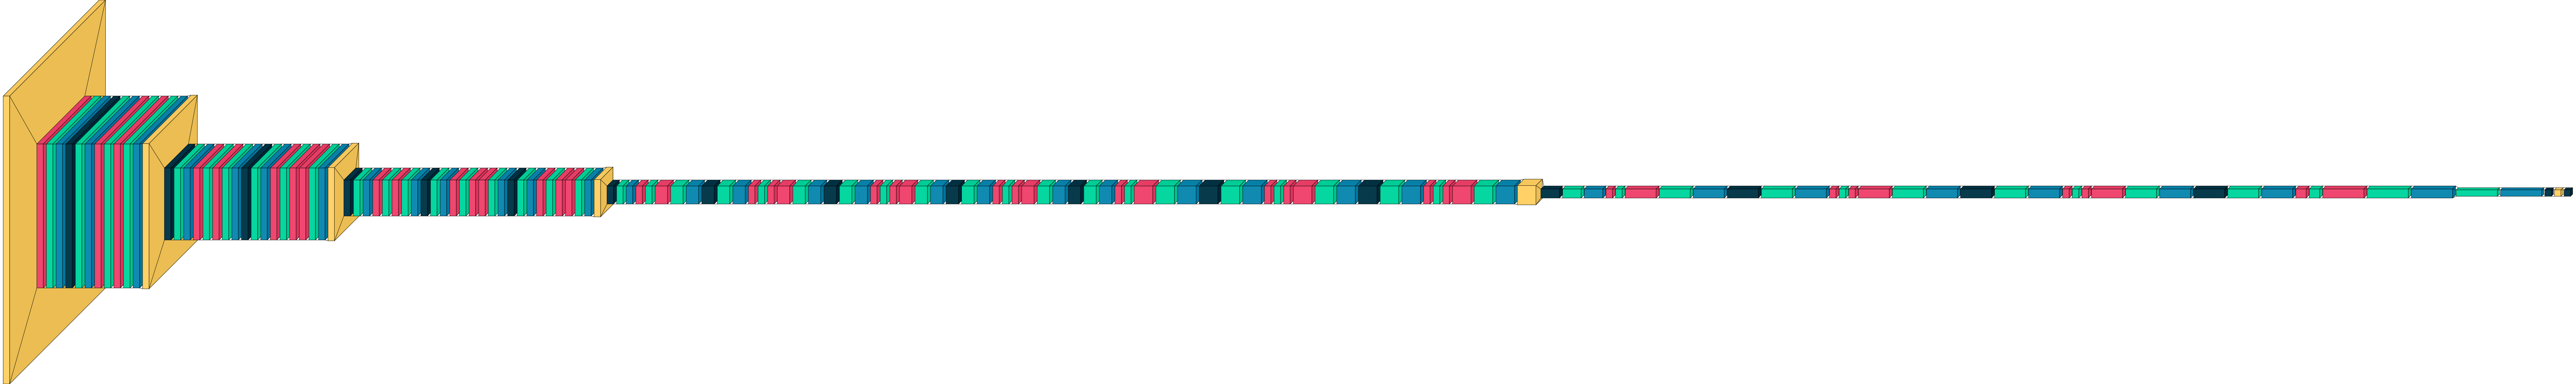

In [21]:
# https://github.com/paulgavrikov/visualkeras

visualkeras.layered_view(model)

#ploting Training accuracy vs Testing accuracy

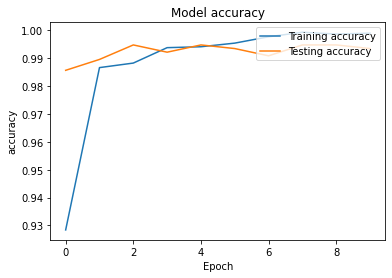

In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training accuracy','Testing accuracy'], loc='upper right')
plt.show()

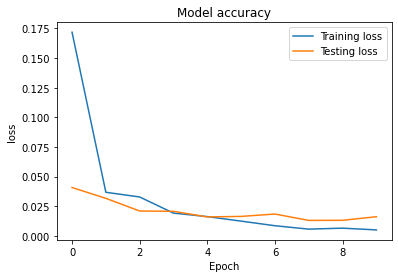

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Training loss','Testing loss'], loc='upper right')
plt.show()